# Load Data


1.   Download data from [Hands.zip](https://raw.github.com/Rafat97/my-tensorflow/dataset/Hands_v2.zip). And save into `./sample_data/Hands.zip` directory.
2.   Unzip the `Hands.zip` file and save into `./content/` directory.



In [ ]:
URL="https://raw.github.com/Rafat97/my-tensorflow/dataset/Hands_v2.zip"
OUTPUT="./sample_data/Hands.zip"
!wget --no-check-certificate \
  $URL\
  -O $OUTPUT

--2021-01-05 07:28:50--  https://raw.github.com/Rafat97/my-tensorflow/dataset/Hands_v2.zip
Resolving raw.github.com (raw.github.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.github.com (raw.github.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/Rafat97/my-tensorflow/dataset/Hands_v2.zip [following]
--2021-01-05 07:28:50--  https://raw.githubusercontent.com/Rafat97/my-tensorflow/dataset/Hands_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14457607 (14M) [application/zip]
Saving to: ‘./sample_data/Hands.zip’

./sample_data/Hands 100%[===================>]  13.79M  36.0MB/s    in 0.4s    

2021-01-05 07:28:52 (36.0 MB/s) - ‘./sample

In [ ]:
!mkdir ./content/  ## creating a directory 
!unzip -u $OUTPUT  -d ./content/ ## unzip the file

In [ ]:
# !rm -rfv ./Hands  ## remove folder

# Image Pre Processing

In [ ]:
# import some importent library or packages 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim

In [ ]:
'''

Get the total file size. Based on your given path

@parem - path - give the file path into string 
@return - integer value
 
Ex :
base_dir = './content/Hands'
train_dir = os.path.join(base_dir, 'train')
total_train_data_size = totalSize(train_dir)

'''
def totalSize(path):
  sum = 0;
  for path, subdirs, files in os.walk(path):  ## walk directory
    sum += len(files)
    # for name in files:
        # print(os.path.join(path, name))
  return sum


In [ ]:
'''

Plotting image spatial for `pytorch`

@parem - image - pytorch tensor image
@parem - ax - input as matplotlib object
@parem - title - give title string 
@parem - normalize - bool value 

@return - matplotlib image object
 
Ex :
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images),normalize=False)

'''
def imshow(image, ax=None, title=None, normalize=True):
  if ax is None:
    fig, ax = plt.subplots() 
  image = image.detach().numpy().transpose((1, 2, 0))  ## for converting dimension (3, 128, 128) to (128, 128, 3) 
  if normalize:
    ## this is depends on dataset. This is ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
  ax.imshow(image)
  return ax

Define directory into some variable 

*   Giving base directory.
*   Then training directory
*   Then validation directory



In [ ]:
base_dir = './content/Hands' 

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

total_train_data_size = totalSize(train_dir)
total_validation_data_size = totalSize(validation_dir)
print("Total Data : ",total_train_data_size + total_validation_data_size) ## Total train & validation data size

Total Data :  3117


Showing some image for dataset

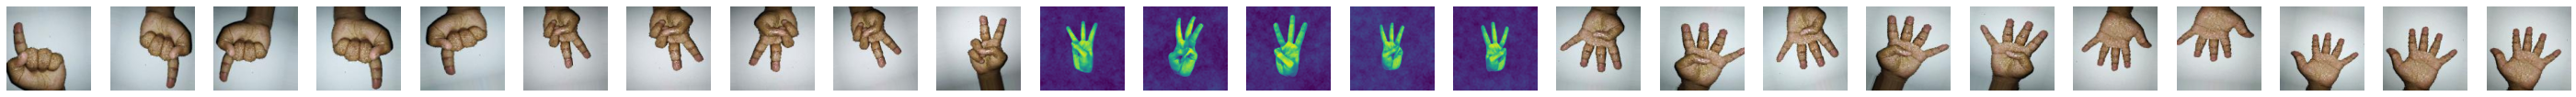

In [ ]:
NUMBER_OF_IMAGE_SHOW = 5  ## how many image you want to show
preview_images_path = []

for path, subdirs, files in os.walk(train_dir):
  subdirs.sort()
  files.sort()
  i = 0;
  for name in files:
    i +=1
    val = str( os.path.join(path, name) )
    preview_images_path.append(val)
    if(i is NUMBER_OF_IMAGE_SHOW):
      break

plt.figure(figsize=(50, 50))
for i,path in enumerate(preview_images_path):
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  plt.subplot(50/2 , 25,i+1)
  # plt.imshow(img)
  plt.axis("off")
  plt.imshow(img[...,::-1]) # RGB-> BGR
plt.show()


In [ ]:
classes = sorted(os.listdir( train_dir )) ## 5 classes into classes variable
classes

['1', '2', '3', '4', '5']

Using torchvision `ImageFolder` load data into tensor 


*   Creating batch of image
*   Give some image transformation 
*   Divided into traning & testing 
*   Define image resolution `128x128`
*   Assign some constent variable. Like `BATCH_SIZE` , `IMAGE_SIZE`


In [ ]:
BATCH_SIZE = 32 ## number of image batch size 
IMAGE_SIZE = 128 ## set image height width to 128x128
transform = transforms.Compose([
                                # transforms.ToPILImage(),
                                # transforms.Grayscale(),
                                transforms.RandomRotation(20,expand=True), ## adding random rotation 20deg
                                torchvision.transforms.ColorJitter(hue=.05, saturation=.05), ## adding color filter
                                transforms.RandomVerticalFlip(), ## adding vertical flip
                                transforms.RandomHorizontalFlip(), ## adding horizontal flip
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

#load training dataset 
dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) 
 
#load validation dataset 
dataset_validation = torchvision.datasets.ImageFolder(validation_dir, transform=transform)
validationloader = torch.utils.data.DataLoader(dataset_validation, batch_size=BATCH_SIZE, shuffle=True)

Showing some image data from training batch 

Image Shape =  torch.Size([32, 3, 128, 128])
Image labels =  tensor([2, 4, 0, 1, 2, 3, 3, 3, 1, 0, 2, 0, 3, 2, 1, 0, 4, 0, 0, 4, 0, 2, 4, 2,
        4, 0, 4, 3, 0, 4, 2, 0])
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


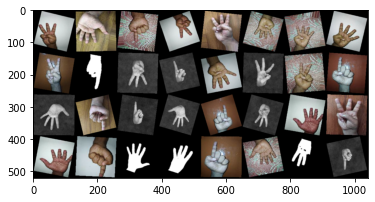

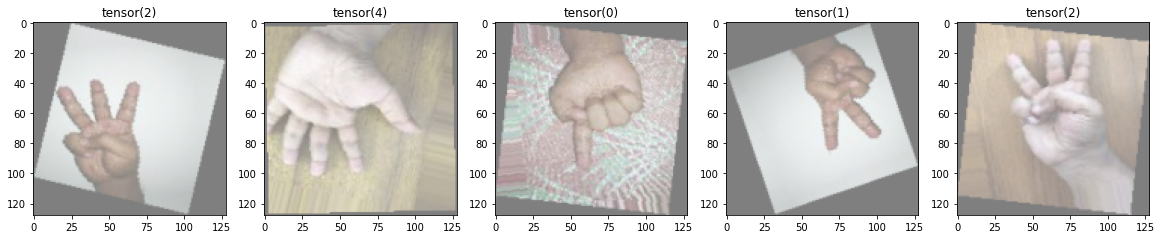

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
imshow(torchvision.utils.make_grid(images),normalize=False)
 
print("Image Shape = ",images.shape)
print("Image labels = ",labels)
 
plt.subplots(figsize=(20, 10))
for i in range(NUMBER_OF_IMAGE_SHOW):
  plt.subplot(NUMBER_OF_IMAGE_SHOW/2, NUMBER_OF_IMAGE_SHOW,i+1)
  img = images[i].detach().numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5]) 
  std = np.array([0.5, 0.5, 0.5])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.title(labels[i])
  print(img.shape)
  plt.imshow(img)
plt.show()

# Custom Model

In [ ]:
'''

For Testing And generated

W = width
H  height
F = filter / kernel_size
P = padding 
S = stride 
 
W = (W−F+2P)/S
H = (H−F+2P)/S

CNN
param = ((shape of width of filter*shape of height filter*number of filters in the previous layer+1)*number of filters)

Linear / Flatten 
param = ((current layer *previous layer) + 1 * current layer )
'''
layer = [
    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), 
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), 
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
    torch.nn.MaxPool2d(2,2),
]
 
 
test_shape = images
print(test_shape.shape)
for lyr in layer:
  x = lyr(test_shape)
  test_shape = x
  print(test_shape.shape)

torch.Size([32, 3, 128, 128])
torch.Size([32, 16, 126, 126])
torch.Size([32, 16, 63, 63])
torch.Size([32, 32, 61, 61])
torch.Size([32, 32, 30, 30])
torch.Size([32, 128, 28, 28])
torch.Size([32, 128, 14, 14])
torch.Size([32, 256, 11, 11])
torch.Size([32, 256, 5, 5])


In [ ]:
'''
Model creation 

'''

class CNN(torch.nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()

        #initializing 4 convolution layer
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)

        #initializing dropout 
        self.dropout = torch.nn.Dropout(0.2)

        #initializing dropout 
        self.pool= torch.nn.MaxPool2d(2,2)
 
        #initializing linear 
        self.fc1 = torch.nn.Linear(256 * 5 * 5, 512)
        self.fc2 = torch.nn.Linear(512, 64)
        self.fc3 = torch.nn.Linear(64, 32)
        self.fc4 = torch.nn.Linear(32, 5)
 
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x))) #sending input into 1st convolution layer,then to relu ,then to pooling layer , param = ((3*3*3)+1)*16 = 448
        x = self.pool(torch.nn.functional.relu(self.conv2(x))) #sending previous output into 2nd convolution layer,then to relu ,then to pooling layer, param = ((3*3*16)+1)*32 = 4640 
        x = self.dropout(x) #dropout unnecessary output
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = self.pool(torch.nn.functional.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(-1, 256 * 5 * 5) # for flatten layer
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        
#select CPU or GPU as a device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=5, bias=True)
)


CONV: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([16, 3, 3, 3])
CONV: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([32, 16, 3, 3])
CONV: Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([128, 32, 3, 3])
CONV: Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1)) ====> SHAPE: torch.Size([256, 128, 4, 4])


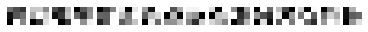

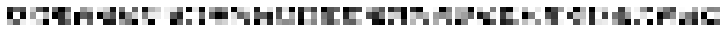

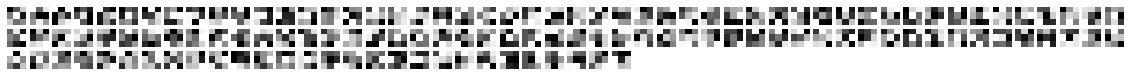

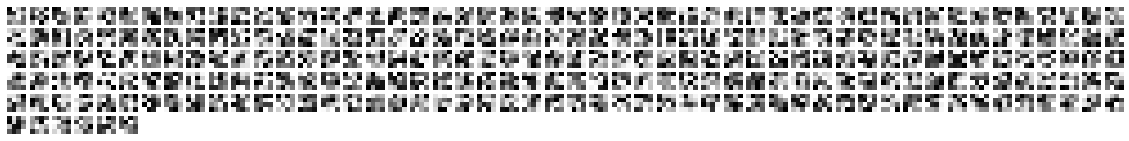

In [ ]:
#instantiating list of model
model_children = list(model.children())
 
model_weights = [] 
conv_layers = [] 
for i in range(len(model_children)):
  if type(model_children[i]) == torch.nn.Conv2d:
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
 
#displaying image after filtering 
for model_single_weights,conv_single_layers in zip(model_weights, conv_layers):
  print(f"CONV: {conv_single_layers} ====> SHAPE: {model_single_weights.shape}")
  plt.figure(figsize=(20, 20))
  for i, filter in enumerate(model_single_weights):
      plt.subplot(50,50,i+1)
      plt.imshow(filter[0, :, :].cpu().detach(),cmap='gray')
      # plt.imshow(filter[0, :, :].cpu().detach().numpy())
      # plt.title("filter "+str(i+1))
      plt.axis("off")
plt.show()

# Model Training Process

In [ ]:
# int((total_train_data_size + total_validation_data_size)/30)
num_classes = 5
batch_size = BATCH_SIZE
learning_rate = 0.001
 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

For Testing

In [ ]:
# # inputs , labels = next(iter(trainloader))
# epochs = 64
# for epoch in range(epochs):
#   for inputs, labels in trainloader:
#       inputs, labels = inputs.to(device), labels.to(device)
          
#       optimizer.zero_grad()
          
#       test = model(inputs)
#       loss = criterion(test, labels)
#       loss.backward()
#       # optimizer.step()
 
#       print(loss)
#       break
    
 
# print('Single Batch Finished Training')

In [ ]:
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 64
steps = 0
running_loss = 0
print_every = 5

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in trainloader:
        model.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward() # computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation
        optimizer.step() # the optimizer to take a step based on the gradients of the parameters.
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validationloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    ## Calculate validation accuracy
                    # ps = torch.exp(logps)
                    # top_p, top_class = ps.topk(1, dim=1)
                    # equals = top_class == labels.view(*top_class.shape)
                    # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(validationloader))
            testaccuracy.append(accuracy/len(validationloader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Validation loss: {test_loss/len(validationloader):f} "
                  f"Validation accuracy: {accuracy/len(validationloader):f}")
            running_loss = 0
            accuracy = 0
            model.train()
print('Finish Train')

Device cuda:0 Epoch 1/64 Step 5 Train loss: 1.617998 Train accuracy: 0.168750 Validation loss: 1.610027 Validation accuracy: 0.141741
Device cuda:0 Epoch 1/64 Step 10 Train loss: 1.612117 Train accuracy: 0.131250 Validation loss: 1.610561 Validation accuracy: 0.195871
Device cuda:0 Epoch 1/64 Step 15 Train loss: 1.613560 Train accuracy: 0.237500 Validation loss: 1.610541 Validation accuracy: 0.199358
Device cuda:0 Epoch 1/64 Step 20 Train loss: 1.614702 Train accuracy: 0.168750 Validation loss: 1.610100 Validation accuracy: 0.195871
Device cuda:0 Epoch 1/64 Step 25 Train loss: 1.619421 Train accuracy: 0.193750 Validation loss: 1.609696 Validation accuracy: 0.217076
Device cuda:0 Epoch 1/64 Step 30 Train loss: 1.611636 Train accuracy: 0.168750 Validation loss: 1.609463 Validation accuracy: 0.199358
Device cuda:0 Epoch 1/64 Step 35 Train loss: 1.611046 Train accuracy: 0.175000 Validation loss: 1.609585 Validation accuracy: 0.192383
Device cuda:0 Epoch 1/64 Step 40 Train loss: 1.609139 Tr

In [ ]:
#display avg test and train accuracy
avg_test = torch.mean( torch.tensor( testaccuracy ))
avg_train = torch.mean( torch.tensor( trainingaccuracy ))
print("last" , trainingaccuracy[len(trainingaccuracy) - 1] ,  testaccuracy[len(testaccuracy) - 1] ,)
print("avg" , avg_train , avg_test)

last tensor(0.9625, device='cuda:0') tensor(0.9467, device='cuda:0')
avg tensor(0.8011) tensor(0.8231)


# Output Visualization & Saving model 

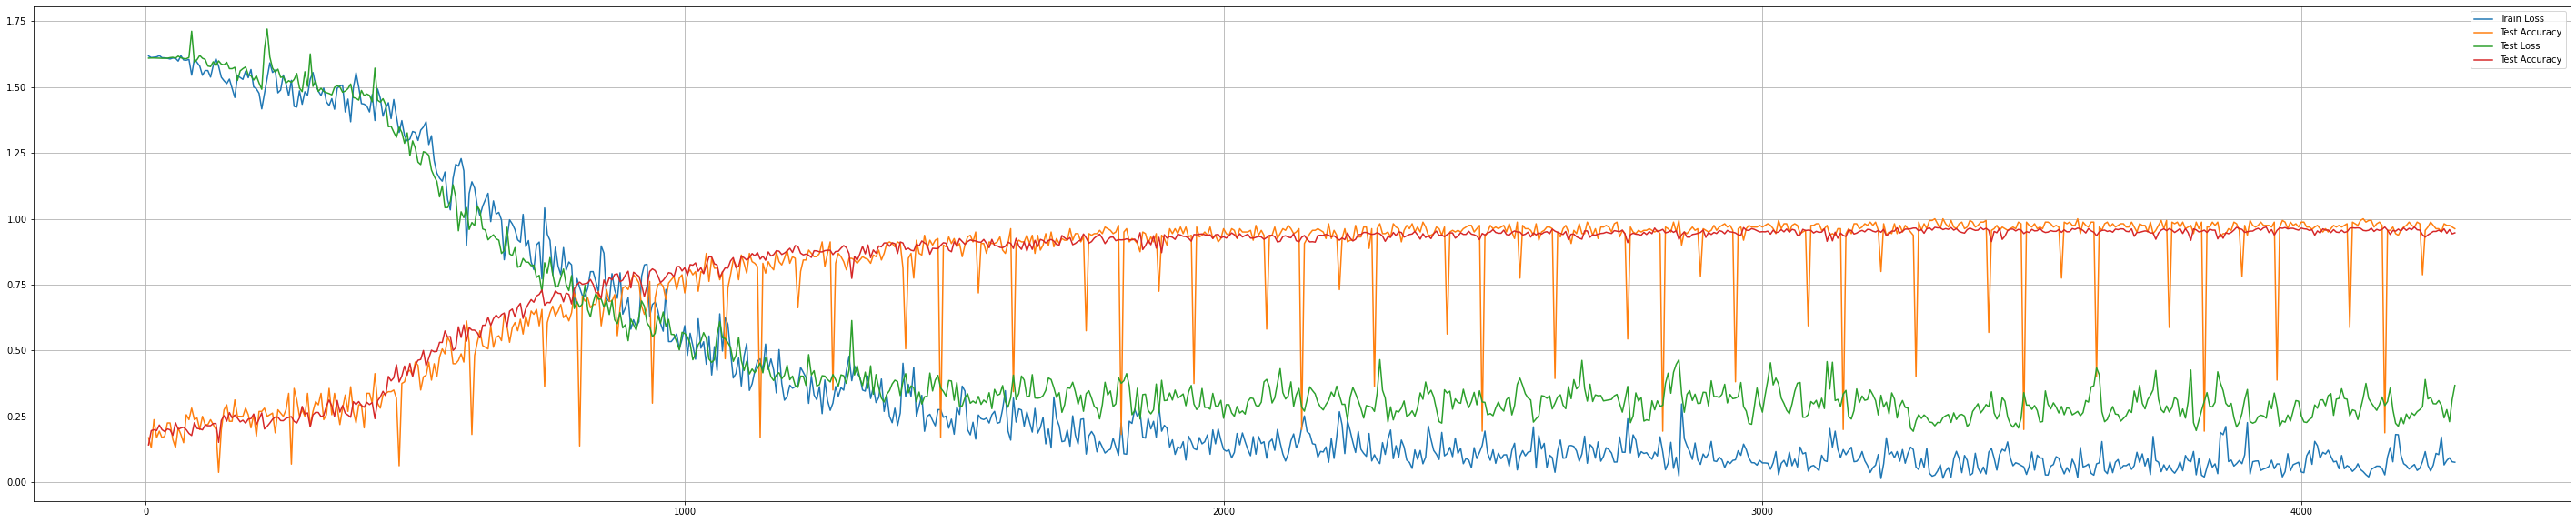

In [ ]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, trainingaccuracy, label='Test Accuracy')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

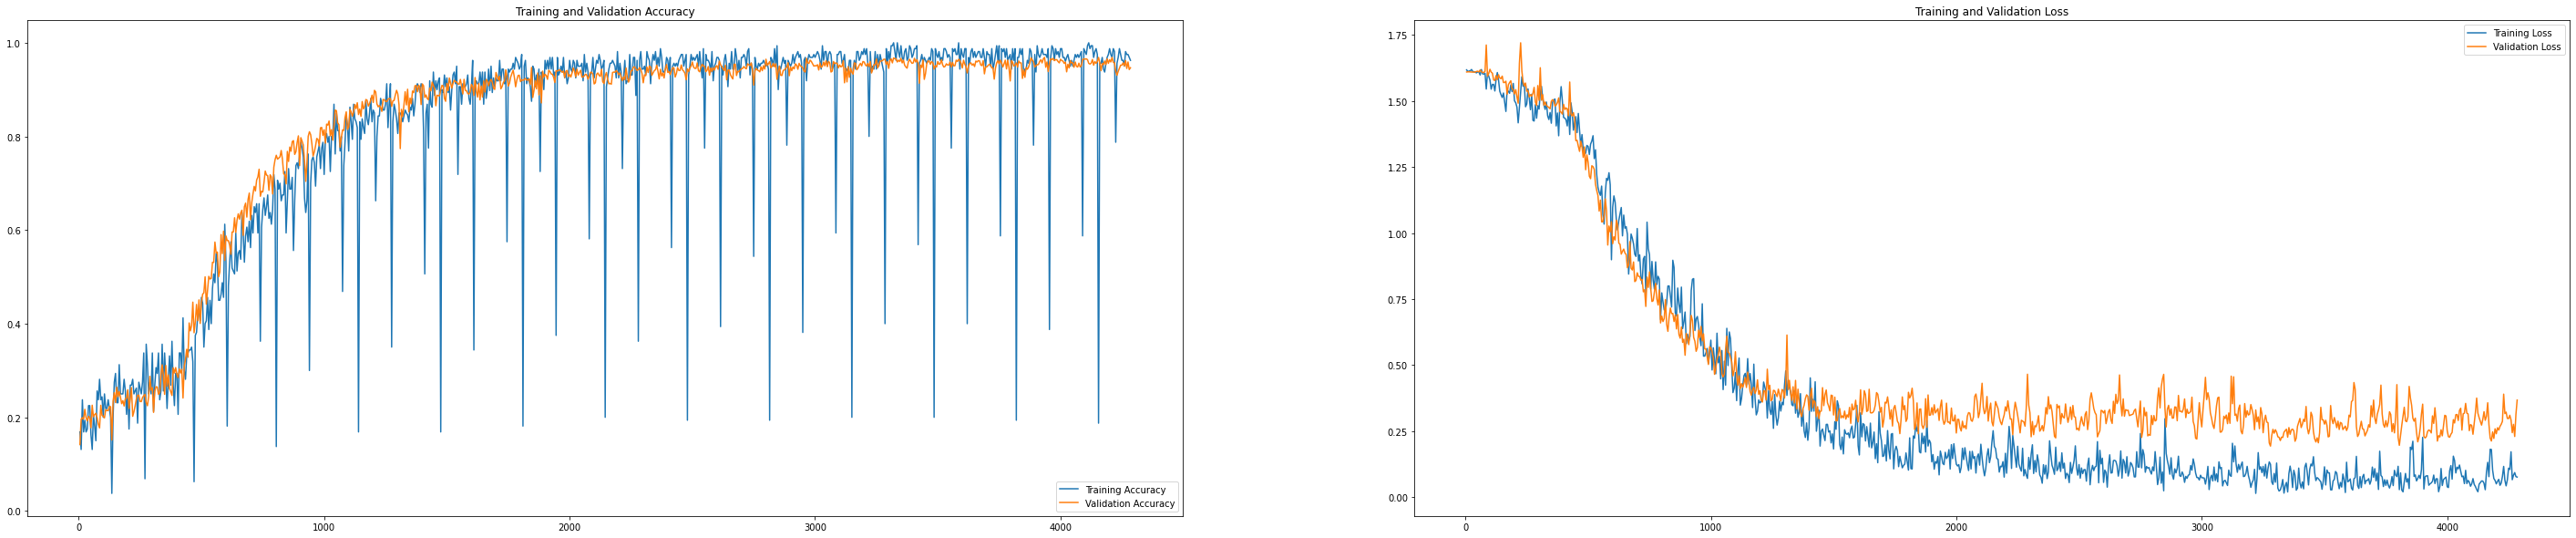

In [ ]:
#display stats in graph
acc = trainingaccuracy
val_acc = testaccuracy

epochs_range = totalsteps

loss = traininglosses
val_loss =  testinglosses

plt.figure(figsize=(50, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

#saving the trained model

PATH = './content/Hand_Finger_Classification_1.pth'
torch.save(model.state_dict(), PATH)

the_model = CNN()
the_model.load_state_dict(torch.load(PATH))

PATH='./content/Hand_Finger_Classification_2.pth'
torch.save(the_model, PATH)


# Testing some data

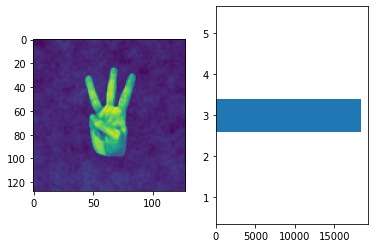

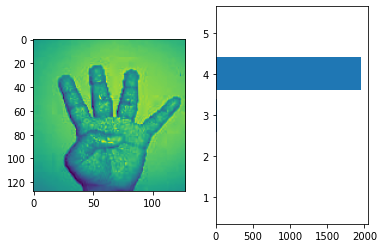

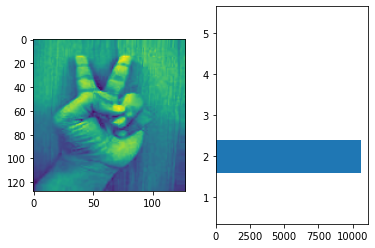

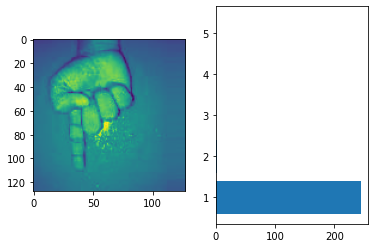

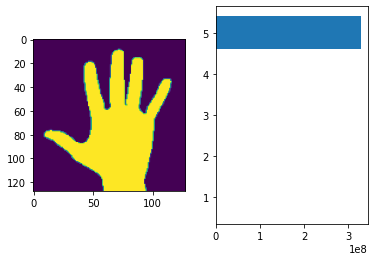

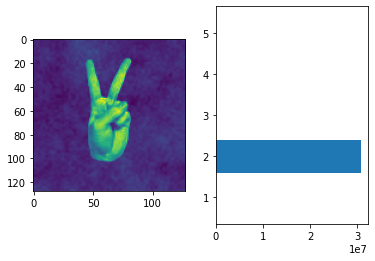

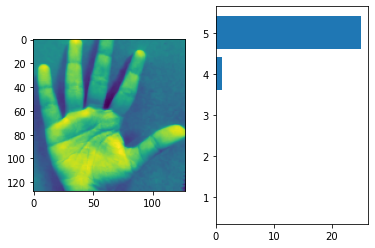

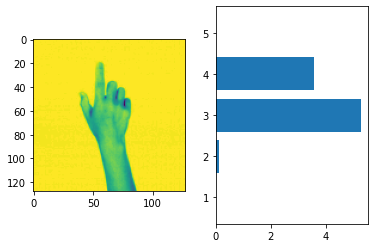

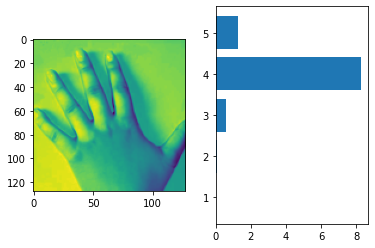

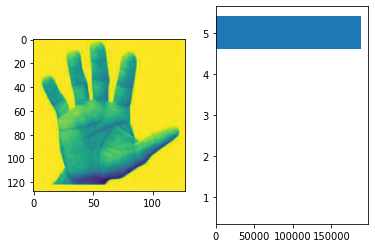

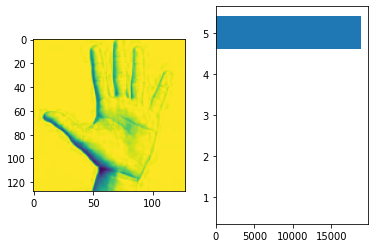

In [ ]:
from PIL import Image

#pre processing image 
transform = transforms.Compose([
                                # transforms.ToPILImage(),
                                # torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                # transforms.RandomVerticalFlip(), 
                                # transforms.RandomHorizontalFlip(),
                                # transforms.RandomRotation(20,expand=True),
                                # transforms.Grayscale(),
                                transforms.Resize(128),
                                transforms.CenterCrop(128),
                                transforms.ToTensor(),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

def image_loader(image_name):
    image = Image.open(image_name)
    image = image.convert('RGB')
    image = transform(image).float()
    image = image.unsqueeze(0) 
    return image  

testing_dir = './content/Hands/test'
test_images_path =[]
for path, subdirs, files in os.walk(testing_dir):
  subdirs.sort()
  files.sort()
  for name in files:
    val = str( os.path.join(path, name) )
    test_images_path.append(val)

for pth in test_images_path:
  path = pth
  img = image_loader(path)
  model.to('cpu')
  model.eval()
  with torch.no_grad():
      output = model.forward(img)
  ps = torch.exp(output)
  probability = ps.data.numpy().squeeze()

  ind = np.arange(5)
  labels = classes
  locations = ind

  plt.subplot(1, 2, 1)
  plt.imshow(img[0,0,:,:])

  plt.subplot(1, 2, 2)
  class_probability = plt.barh(ind, probability)
  plt.yticks(locations, labels)

  plt.show();


In [ ]:
from google.colab import files
from PIL import Image

transform = transforms.Compose([
                                # transforms.ToPILImage(),
                                # torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                # transforms.RandomVerticalFlip(), 
                                # transforms.RandomHorizontalFlip(),
                                # transforms.RandomRotation(20,expand=True),
                                # transforms.Grayscale(),
                                transforms.Resize(128),
                                transforms.CenterCrop(128),
                                transforms.ToTensor(),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

def image_loader(image_name):
    image = Image.open(image_name)
    image = image.convert('RGB')
    print(img.shape)
    image = transform(image).float()
    image = image.unsqueeze(0) 
    return image  

probability = None
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image_loader(path)
  imshow(img[0,:] )
  # imshow(img)
  model.to('cpu')
  model.eval()
  print(img.shape)
  with torch.no_grad():
      output = model.forward(img)
  ps = torch.exp(output)
  probability = ps.data.numpy().squeeze()

# output

In [ ]:
ind = np.arange(5)
labels = classes
width = 0.3
locations = ind

class_probability = plt.barh(ind, probability)

plt.title('Class Probability')
plt.yticks(locations, labels)

plt.show();

In [ ]:
%%html
<center>
<h1><b>--- Thank You! ---</b></h1>
</center>

In [ ]:
!kill -9 -1

In [ ]:
exit()

# Thank You